## Movie Recommender System 

### Objective:
    * To recommend user all-time top 10 movies out of relevant and irrelevant collection of movies based on Movie Score (Simple Recommender System).
    * To recommend user a similar type of movies based on user's previous choices in same genres (Content Based Filtering).

### Dataset:
    * MovieLens data set is used that provides 25 Million user ratings on 62.5K movies by 162541 users between Jan 1995 to Nov 2019.
    * All user rated at least 20 movies.

### Approach:
    1) Simple Recommender System:
        * Movie Score calculated based on Weighted Average Ratings using IMDb's Formula.
        * We can recommend Top 10 Movies with higher Movie Score.
    2) Content Based Filtering:
        * Jaccard Score has used to calculate correlation/similarity between two movies based on Genres.
        * Higher the Jaccard Score, higher the similarity between two movies, So we can recommend movies with higher Jaccard score.

#### Importing Required Librabies

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
## Reading  Datasets
ratings = pd.read_csv(r'C:\Users\91892\Documents\Python_jupyter\Machine Learning\Recommender System\ratings.csv')
movies = pd.read_csv(r'C:\Users\91892\Documents\Python_jupyter\Machine Learning\Recommender System\movies.csv')


In [38]:
# Creating a backup
movies_backup = movies.copy()
movies_2 = movies.copy()
ratings_backup = ratings.copy()

In [39]:
# Viewing dataset
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [40]:
# Viewing dataset
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


* The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [41]:
# Make a census of the genre keywords
gen = movies['genres']
genre_freq = {}
for line in gen:
    line = line.replace('|', " ")
    line = line.split()
    #print(line)
    for word in line:
        word = word.split()
        word = word[0]
        #print(word)
        genre_freq[word] = genre_freq.get(word, 0) + 1

## Most frequent Genres watched by user

* The top 5 genres are, in that respect order: Drama, Comedy, Action, Thriller, and Romance. I'll show this on a wordcloud too in order to make it more visually appealing.

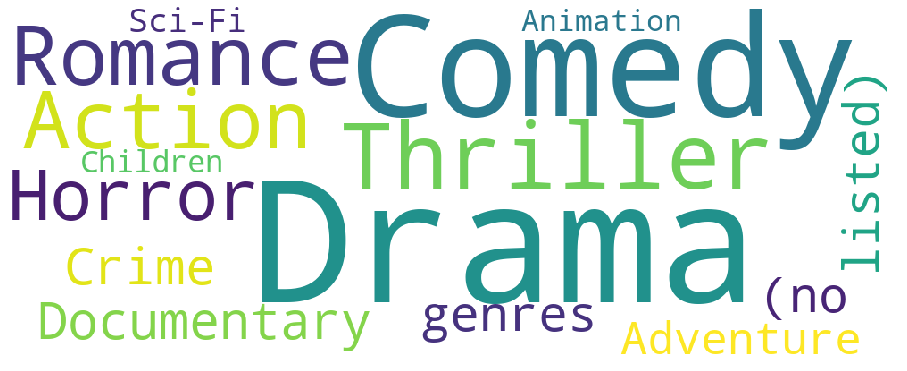

In [42]:
# Import new libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
comb_wprd = WordCloud(background_color="white",width=1000,height=400, max_words=15,
                      relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(genre_freq)
plt.figure(figsize=(16,8))
plt.imshow(comb_wprd)
plt.axis('off')
plt.show()


## Simple Recommender

In [43]:
ratings_crosstab = pd.crosstab(ratings['movieId'], ratings['rating'], margins = True).reset_index().fillna(0)
#adding margins will subtotal across rows

In [44]:
ratings_crosstab.head()

rating,movieId,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
0,1,406,665,395,1734,1459,9463,5478,18874,5329,13506,57309
1,2,259,706,496,2240,1701,7680,2870,5609,780,1887,24228
2,3,135,602,189,1332,514,4727,631,2511,124,1039,11804
3,4,48,291,26,437,65,964,55,455,11,171,2523
4,5,197,611,230,1351,548,5008,608,2193,128,840,11714


In [45]:
ratings_crosstab.shape

(59048, 12)

In [46]:
ratings_crosstab.rename(columns = {'All':'v-no-ofvotesof-movie'}, inplace = True)
ratings_crosstab.head();

In [47]:
# Creating An array to multiply with df to calculate weightage average
arr = np.arange(0.5,5.1,0.5)
arr

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

### Weightage Average calculation

In [48]:
ratings_crosstab["R-Avg_rating"]=(arr*ratings_crosstab.iloc[:, 1:11]).sum(axis=1)/ratings_crosstab['v-no-ofvotesof-movie']

In [60]:
ratings_crosstab.head()

rating,movieId,v-no-ofvotesof-movie,R-Avg_rating
0,1,57309,3.893708
1,2,24228,3.251527
2,3,11804,3.142028
3,4,2523,2.853547
4,5,11714,3.058434


In [50]:
ratings_crosstab = ratings_crosstab[['movieId', 'v-no-ofvotesof-movie', 'R-Avg_rating']]

In [51]:
ratings_crosstab.sort_values(by ='R-Avg_rating', ascending=False);

### IMDB Score Calculation

In [61]:
# C is Avergae Rating of all the Movies
C= ratings_crosstab['R-Avg_rating'].mean()  
C

3.0713817532321848

In [62]:
# m is Minimum No of votes a movie should have.
m= ratings_crosstab['v-no-ofvotesof-movie'].quantile(0.90)
m

413.0

In [63]:
# Function to Cal IMDB Score
def weighted_rating(x, m=m, C=C):
    v = x['v-no-ofvotesof-movie']
    R = x['R-Avg_rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [64]:
ratings_crosstab.shape

(59048, 3)

In [65]:
q_movies = ratings_crosstab.copy().loc[ratings_crosstab['v-no-ofvotesof-movie'] >= m]
q_movies.shape

(5910, 3)

In [69]:
# IMDB Score 
q_movies.head();

In [68]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies.iloc[0:5]

rating,movieId,v-no-ofvotesof-movie,R-Avg_rating,score
0,1,57309,3.893708,3.887824
1,2,24228,3.251527,3.248508
2,3,11804,3.142028,3.139640
3,4,2523,2.853547,2.884190
4,5,11714,3.058434,3.058875


In [70]:
# Merging Tables to get MOvie ID, Title and score together
movies_title = movies.iloc[:,0:2]
q_movies = q_movies.merge(movies_title,on='movieId')

In [71]:
q_movies.head(5)

,movieId,v-no-ofvotesof-movie,R-Avg_rating,score,title
0,1,57309,3.893708,3.887824,Toy Story (1995)
1,2,24228,3.251527,3.248508,Jumanji (1995)
2,3,11804,3.142028,3.139640,Grumpier Old Men (1995)
3,4,2523,2.853547,2.884190,Waiting to Exhale (1995)
4,5,11714,3.058434,3.058875,Father of the Bride Part II (1995)


# Top 10 Recommended Movies by Simple Recomender System

In [72]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 10 movies
q_movies[['movieId','title', 'v-no-ofvotesof-movie','score']].head(10)

,movieId,title,v-no-ofvotesof-movie,score
257,318,"Shawshank Redemption, The (1994)",81482,4.406807
601,858,"Godfather, The (1972)",52498,4.314556
46,50,"Usual Suspects, The (1995)",55366,4.275372
834,1221,"Godfather: Part II, The (1974)",34188,4.247550
428,527,Schindler's List (1993),60411,4.239593
1964,2959,Fight Club (1999),58773,4.220238
1331,2019,Seven Samurai (Shichinin no samurai) (1954),13367,4.219302
624,904,Rear Window (1954),20162,4.214531
817,1203,12 Angry Men (1957),16569,4.214520
808,1193,One Flew Over the Cuckoo's Nest (1975),36058,4.205670


## Content Based Recommender

In [73]:
# Splitting the Genres column into multiple columns and stacking it
movies_stacked = movies_2.set_index('movieId').genres.str.split('|', expand=True).stack()

movies_df = pd.get_dummies(movies_stacked, prefix='genre').groupby(level=0).sum()

movies_df

,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209157,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
209159,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
209163,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [74]:
from sklearn.metrics import jaccard_score

In [75]:
# Merging table to get Movie ID, score, title and genres
df_main = q_movies[['movieId','score']]
df_main = pd.merge(left = df_main, right= movies, left_on= 'movieId', right_on= 'movieId')

In [76]:
df_main

,movieId,score,title,genres
0,318,4.406807,"Shawshank Redemption, The (1994)",Crime|Drama
1,858,4.314556,"Godfather, The (1972)",Crime|Drama
2,50,4.275372,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
3,1221,4.247550,"Godfather: Part II, The (1974)",Crime|Drama
4,527,4.239593,Schindler's List (1993),Drama|War
...,...,...,...,...
5904,31698,1.958395,Son of the Mask (2005),Adventure|Children|Comedy|Fantasy
5905,50798,1.875694,Epic Movie (2007),Adventure|Comedy
5906,6587,1.869326,Gigli (2003),Comedy|Crime|Romance
5907,4775,1.868282,Glitter (2001),Drama|Musical|Romance


In [77]:
# Reseting Index so that we can run loop properly
movies_df1 = movies_df.reset_index()
movies_df1;

In [78]:
### Content Based Filtering Function

In [79]:
def Content_Based(mov_Id):
    #mov_Id = int(input("Enter Movie ID: "))
    if mov_Id not in movies_df1.movieId:
        print("Incorrect Movie ID")

    else:
        result = []
        indx = int(movies_df1[movies_df1['movieId'] == mov_Id].index.values.astype(int))
        for i in df_main.movieId: 
            row = int(movies_df1[movies_df1['movieId']== i].index.values.astype(int))
            j_s = jaccard_score(movies_df1.iloc[indx, 1:], movies_df1.iloc[row, 1:])
            if len(result) <= 10:
                result.append((j_s, float(df_main['score'][df_main['movieId'] == i].values), i))

            else: # len(result) > 15:
                result.sort(reverse = True)
                if j_s > min(result)[0]:
                    result[9] = (j_s, float(df_main['score'][df_main['movieId'] == i].values), i)


        recommended_mov = pd.DataFrame(result, columns=['Jacard Score', 'Score', 'movieId',])
        recommended_mov = recommended_mov.sort_values(by = ['Jacard Score', 'Score'], ascending = False)
        final = pd.merge(left = recommended_mov, right =df_main , right_on= 'movieId', left_on= 'movieId')
        print("Watched Movie :")
        print(pd.DataFrame(df_main[df_main['movieId']== mov_Id]))
        print("Recommended Movies are: ")
    return(final)

# Content Based Recommended movies 

In [82]:
Content_Based(45)

Watched Movie :
     movieId     score              title                 genres
2745      45  3.368085  To Die For (1995)  Comedy|Drama|Thriller
Recommended Movies are: 


,Jacard Score,Score,movieId,score,title,genres
0,1.00,3.922987,116897,3.922987,Wild Tales (2014),Comedy|Drama|Thriller
1,1.00,3.734661,319,3.734661,Shallow Grave (1994),Comedy|Drama|Thriller
2,1.00,3.368085,45,3.368085,To Die For (1995),Comedy|Drama|Thriller
3,1.00,3.321871,41716,3.321871,"Matador, The (2005)",Comedy|Drama|Thriller
4,1.00,3.289887,105835,3.289887,"Double, The (2013)",Comedy|Drama|Thriller
5,1.00,3.062540,91128,3.062540,"Rum Diary, The (2011)",Comedy|Drama|Thriller
6,0.75,4.183149,296,4.183149,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
7,0.75,4.102516,608,4.102516,Fargo (1996),Comedy|Crime|Drama|Thriller
8,0.75,3.856352,57669,3.856352,In Bruges (2008),Comedy|Crime|Drama|Thriller
9,0.25,1.875694,50798,1.875694,Epic Movie (2007),Adventure|Comedy
